Brandon Wilfong

PHYS476 -- Final Project

For this final project, we will look at the use of neural network models to learn atomization energies for small organic molecules based calculated nuclear charge and atomic positions within the molecules. 

The dataset used can be obtained from: http://quantum-machine.org/datasets/

L. C. Blum, J.-L. Reymond, 970 Million Druglike Small Molecules for Virtual Screening in the Chemical Universe Database GDB-13, J. Am. Chem. Soc., 131:8732, 2009.
M. Rupp, A. Tkatchenko, K.-R. Müller, O. A. von Lilienfeld: Fast and Accurate Modeling of Molecular Atomization Energies with Machine Learning, Physical Review Letters, 108(5):058301, 2012.

Thie dataset consists of a subset of the GDB-13 dataset which contains the the Coulomb matrix representation of these molecules and their atomization energies computed from DFT using the Perdew-Burke-Ernzerhof hybrid functional (PBE).



The Coulomb matrix representation of the atomic positions and nuclear charge requires the knowledge of the molecular structure of these systems. With this, the Coulombic interaction between all atoms within the molecule can be calculated and this is represented in matrix format via the formula:

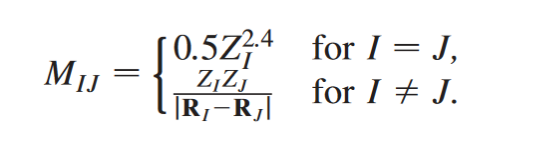

Where Ri and Rj are the positions of the i-th and j-th atom in the molecule and Zi and Zj are the nuclear charge of the i-th and j-th atom. From these two points, we have information regarding the structural and elemental make-up of the molecule. 

The dataset used consists of 7165 molecules, with the largest molecules containing 23 atoms, so the total size of the Coulomb matrix representation considered here is (7165 x 23 x 23) with a (7165 x 1) vector corresponding to the atomization energy for each molecule. 

There has been some previous work on this dataset: 

Rupp et al. PRL, 2012 | Kernel ridge regression with Gaussian Kernel on Coulomb matrix sorted eigenspectrum | 9.9kcal/mol

Montavon et al. NIPS, 2012 | Multilayer perceptron with binarized random Coulomb matrices | 3.5 kcal/mol
    
However, I plan to use convolutional neural networks to attempt to model this problem. This is due to the fact that the (23 x 23) Coulomb matrix is an image-like representation of the electronic energy of each molecule. For each molecule, depending on the atomic arrangement and composition, there are only a couple bonds which make up the bulk of the energetic concerns for the system. 

For example, in ethane, H3C-CH3, the C-C bond is about 20% weaker than the C-H bonds. 
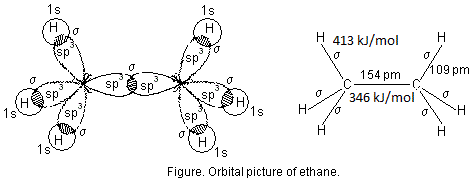
Thus, we may be able to use convolutional neural networks to optimize the Coulomb matrix representation and focus in on only the most important features of a molecule and attempt to learn the atomization energy from this electronic and structural information.

    

In [1]:
import os,sys, numpy, scipy, scipy.io
import pandas as pd
import tensorflow as tf
import numpy as np
seed  = 42
numpy.random.seed(seed)
dataset = scipy.io.loadmat('qm7.mat')
data = pd.DataFrame([dataset], columns = dataset.keys())
data.head()

,__globals__,X,R,T,Z,__version__,P,__header__
0,[],"[[[36.8581, 2.90763, 2.90761, 2.90756, 2.90535...","[[[1.88644, -0.00464873, -0.00823921], [3.9499...","[[-417.96, -712.42, -564.21, -404.88, -808.87,...","[[6.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",1.0,"[[5578, 2504, 4851, 3130, 6670, 2010, 1421, 43...","b'MATLAB 5.0 MAT-file Platform: posix, Created..."


Now, we can evaluate how the data is arranged. Z = (7165 x 3) array of Cartesian coordinates of each atom in molecule, R = (7165 x 1) array of atomic charge of each atom in the molecule, X = (7165 x 23 x 23) array of the Coulomb matrix representation of each molecule, T = (7165 x 1) array of atomization energy for each molecule, and P = (5 x 1433) cross-validation splits)

In [2]:
del data
data = scipy.io.loadmat('qm7.mat')
split = 2 #mini-batch size used for training.

P = data['P'][list(range(0,split))+list(range(split+1,5))].flatten()
X = data['X'][P]
T = data['T'][0,P]
print(X.shape, T.shape)

P_test = data['P'][2].flatten()
X_test = data['X'][P_test]
T_test = data['T'][0,P_test]

(5732, 23, 23) (5732,)


In [14]:
# Training Parameters
learning_rate = 0.001
num_steps = 10000
batch_size = 10
img_size = 23
num_channels = 1
num_classes = 1

# Now, we need to initialize all our variables for the Tensorflow network.
session = tf.Session()
x = tf.placeholder(tf.float32, shape = [None, img_size, img_size, num_channels], name = 'x')
y = tf.placeholder(tf.float32, shape = [None, num_classes], name = 'y')

In [15]:
def next_batch(num, data, labels):
    # Return a total of `num` random samples and labels. 
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

# We can define functions for all the different layers of the neural network
# This way we can be more general in the neural network architecture.

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape = [size]))

def create_convolutional_layer(input, num_input_channels, conv_filter_size, num_filters):  
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape = [conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer -- stride size determines the movement of the filter
    layer = tf.nn.conv2d(input = input, filter = weights, strides = [1, 1, 1, 1], padding='SAME')

    layer += biases

    ## We shall be using max-pooling on a region after the filtered convolution step.
    layer = tf.nn.max_pool(value = layer, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding='SAME')
    ## Output of pooling is fed to ReLU.
    layer = tf.nn.relu(layer)

    return layer

def create_flatten_layer(layer):
    layer_shape = layer.get_shape()

    ## Number of features will be img_height * img_width * num_channels..
    num_features = layer_shape[1:4].num_elements()

    ## Now, we Flatten the layer so we shall have to reshape to num_features
    layer = tf.reshape(layer, [-1, num_features])

    return layer


def create_fc_layer(input, num_inputs, num_outputs, use_relu = True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b. Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [16]:
def conv_model(x, filter_size_conv1, filters1, filter_size_conv2, 
                filters2, num_channels, num_classes, fc_layer_size1, fc_layer_size2):
    # These will be the parameters used for the layers of the neural network.
    filter_size_conv1 = filter_size_conv1 
    num_filters_conv1 = filters1
    filter_size_conv2 = filter_size_conv2
    num_filters_conv2 = filters2
    num_classes = num_classes #one output of atomization energy
    fc_layer_size1 = fc_layer_size1 #Size of the fc layer
    fc_layer_size2 = fc_layer_size2 #Size of the fc layer


    # From here, we can build the neural network architecture by calling functions for each 
    layer_conv1 = create_convolutional_layer(input = x, num_input_channels = num_channels, conv_filter_size = filter_size_conv1, num_filters = num_filters_conv1)
    #print(layer_conv1.get_shape())
    layer_conv2 = create_convolutional_layer(input = layer_conv1, num_input_channels = num_filters_conv1, conv_filter_size = filter_size_conv2, num_filters = num_filters_conv2) 
    #print(layer_conv2.get_shape())
    layer_flat = create_flatten_layer(layer_conv2)
    print(layer_flat.get_shape())
    layer_fc1 = create_fc_layer(input = layer_flat, num_inputs = layer_flat.get_shape()[1:4].num_elements(), num_outputs = fc_layer_size1, use_relu = True)
    #print(layer_fc1.get_shape())
    layer_fc2 = create_fc_layer(input = layer_fc1, num_inputs = layer_fc1.get_shape()[1:4].num_elements(), num_outputs = fc_layer_size2, use_relu = True)
    #print(layer_fc2.get_shape())
    output = create_fc_layer(input = layer_fc2, num_inputs = layer_fc2.get_shape()[1:4].num_elements(), num_outputs = num_classes, use_relu = False)
    #print(layer_output.get_shape())
    return output


In [17]:
pred = conv_model(x, 12, 8, 6, 16, 1, 1, 4232, 65)
loss = tf.reduce_mean(tf.squared_difference(pred, y))
#loss = tf.reduce_mean(tf.abs(pred - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
accuracy = tf.reduce_mean(tf.abs(pred - y))

# Initialize global variables for Tensorflow.
session.run(tf.global_variables_initializer()) 
init = tf.global_variables_initializer()
# Implemented function to show the epochs and accuracy of the network training. 
def show_progress(epoch, feed_dict_train):
    acc = session.run(accuracy, feed_dict = feed_dict_train)
    prediction = session.run(pred, feed_dict = feed_dict_train)
    print("Epoch:", epoch + 1, "      Mean Absolute Error:" , acc)

# Implemented function to execute the modeling training. 
total_iterations = 0
def train(num_iteration):
    global total_iterations
    
    for i in range(total_iterations, total_iterations + num_iteration):
        x_batch, y_batch = next_batch(batch_size, X, T)
        x_batch = np.reshape(x_batch, (-1, 23, 23, 1))
        y_batch = np.reshape(y_batch, (batch_size, 1))
        feed_dict_train = {x: x_batch, y: y_batch,}
        session.run(optimizer, feed_dict = feed_dict_train)
        if i % int(len(X)/batch_size) == 0: 
            epoch = int(i/int(len(X)/batch_size))    
            show_progress(epoch, feed_dict_train)
    
    total_iterations += num_iteration

(?, 8464)


In [18]:
# Train the model!
train(num_iteration = num_steps)
X_test = np.reshape(X_test, (-1, 23, 23, 1))
T_test = np.reshape(T_test, (1433, 1))
testing = session.run(accuracy, feed_dict = {x: X_test, y: T_test})
print("Test Accuracy: ",  testing)


Epoch: 1       Mean Absolute Error: 1518.06
Epoch: 2       Mean Absolute Error: 52.8196
Epoch: 3       Mean Absolute Error: 28.0004
Epoch: 4       Mean Absolute Error: 13.7982
Epoch: 5       Mean Absolute Error: 38.3967
Epoch: 6       Mean Absolute Error: 15.6882
Epoch: 7       Mean Absolute Error: 11.1498
Epoch: 8       Mean Absolute Error: 24.366
Epoch: 9       Mean Absolute Error: 19.9231
Epoch: 10       Mean Absolute Error: 24.3785
Epoch: 11       Mean Absolute Error: 19.1828
Epoch: 12       Mean Absolute Error: 26.6926
Epoch: 13       Mean Absolute Error: 15.8588
Epoch: 14       Mean Absolute Error: 11.0555
Epoch: 15       Mean Absolute Error: 12.157
Epoch: 16       Mean Absolute Error: 18.9055
Epoch: 17       Mean Absolute Error: 12.6611
Epoch: 18       Mean Absolute Error: 14.7963
Test Accuracy:  17.9049
